# Lab 12. Model regresyjny

## 1. Budowa modelu regresyjnego do predykcji ceny mieszkań

### 1.1 Wstępna analiza i przygotowanie danych

In [89]:
# import niezbędnych bibliotek
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

Dane, na których zaprezentowany zostanie przykład to dane z serwisu www.kaggle.com.

**Dataset:** https://www.kaggle.com/datasets/amrahhasanov23/otodom-pl-flat-prices-in-poland

In [62]:
!pip install kagglehub

In [63]:
import kagglehub

# plik pobiera się niestety bez podania ścieżki docelowej, więc zapewne będzie to jakiś folder tymczasowy
path = kagglehub.dataset_download("amrahhasanov23/otodom-pl-flat-prices-in-poland")

print("Ścieżka do pliku:", path)

Ścieżka do pliku: /kaggle/input/otodom-pl-flat-prices-in-poland


In [64]:
# deklarujemy stałą, która będzie niezmienna (to znowu taka umowa/konwencja), która wskazuje na ścieżkę do głównego
# katalogu z danymi dla tego notebooka
DATAPATH = './data'

import os

os.makedirs(DATAPATH, exist_ok=True)

In [65]:
# przeniesiemy plik do folderu z danymi, który utworzyliśmy wcześniej
import shutil

# zakładamy, że jest tam tylko jeden plik, więc listujemy folder i pobieramy pierwszą nazwę pliku
filename = os.listdir(path)[0]

shutil.copy(os.path.join(path, filename), os.path.join(DATAPATH, filename))

'./data/Otodom_Flat_Listings.csv'

In [66]:
# sprawdzamy czy plik faktycznie się przeniósł
os.listdir(DATAPATH)

['Otodom_Flat_Listings.csv']

Alternatywnie można oczywiście pobrać zbiór bezpośrednioze strony internetowej, rozpakować go i umieścić w folderze docelowym.

Zobaczmy teraz jak wyglądają nasze dane. Zachęcam również do spojrzenia na **datacard** tego zbioru na stronie serwisu Kaggle.

In [67]:
otodf = pd.read_csv(os.path.join(DATAPATH, filename))
otodf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2807 entries, 0 to 2806
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   2807 non-null   object 
 1   Price                   2664 non-null   float64
 2   Location                2806 non-null   object 
 3   Surface                 2807 non-null   float64
 4   Number_of_Rooms         2807 non-null   object 
 5   Floor                   2743 non-null   object 
 6   Finishing_Condition     2229 non-null   object 
 7   Heating                 2060 non-null   object 
 8   Parking_Space           1478 non-null   object 
 9   Balcony_Garden_Terrace  2102 non-null   object 
 10  Link                    2807 non-null   object 
 11  Voivodeship             2806 non-null   object 
 12  City                    2806 non-null   object 
dtypes: float64(2), object(11)
memory usage: 285.2+ KB


In [68]:
otodf.head()

,Title,Price,Location,Surface,Number_of_Rooms,Floor,Finishing_Condition,Heating,Parking_Space,Balcony_Garden_Terrace,Link,Voivodeship,City
0,2 pokoje 47m2 po remoncie + garderoba + balkon,415000.000,"ul. Marysińska, Stare Bałuty, Bałuty, Łódź, łó...",47.000,2,NaN,do zamieszkania,miejskie,garaż/miejsce parkingowe,balkon,https://www.otodom.pl/pl/oferta/2-pokoje-47m2-...,Łódzkie,Łódź
1,Właściciel- Ludwiki DD - WIDOK NA ZIELEŃ - 2x gar,2499000.000,"ul. Ludwiki, Czyste, Wola, Warszawa, mazowieckie",105.000,4,2/8,do wykończenia,miejskie,garaż/miejsce parkingowe,balkon,https://www.otodom.pl/pl/oferta/wlasciciel-lud...,Mazowieckie,Warszawa
2,"Sprzedam mieszkanie 60m2, 2 balkony, garderoba",649000.000,"ul. Londyńska, Gorzów Wielkopolski, lubuskie",60.000,3,4/4,do zamieszkania,miejskie,NaN,"balkon, taras",https://www.otodom.pl/pl/oferta/sprzedam-miesz...,Lubuskie,Gorzów Wielkopolski
3,"Wyjątkowy, duży apartament z antresolą",2108000.000,"Mrzeżyno, Trzebiatów, gryficki, zachodniopomor...",78.300,3,4/4,do wykończenia,NaN,garaż/miejsce parkingowe,NaN,https://www.otodom.pl/pl/oferta/wyjatkowy-duzy...,Zachodniopomorskie,gryficki
4,"2/3-pok. 49,2 m2 w samym sercu Koszalina - Kuncer",450180.000,"ul. Bartosza Głowackiego, Koszalin, zachodniop...",49.200,2,2/3,do zamieszkania,miejskie,garaż/miejsce parkingowe,balkon,https://www.otodom.pl/pl/oferta/2-3-pok-49-2-m...,Zachodniopomorskie,Koszalin


In [69]:
otodf.isna().sum()

,0
Title,0
Price,143
Location,1
Surface,0
Number_of_Rooms,0
Floor,64
Finishing_Condition,578
Heating,747
Parking_Space,1329
Balcony_Garden_Terrace,705


Trzeba przyznać, że w zbiorze jest sporo elementów, nad którymi należy popracować zanim będzie można dane "wrzucić" do modelu ML i liczyć na jakieś sensowne wyniki. Sporo jest danych tekstowych, które w takiej formie na pewno nam się nie przydadzą, ale po ich przekształceniu powinniśmy uzyskać lepsze rezultaty - chociaż aktualnie jest to niestety "wróżenie z fusów" ;-).

W zbiorze sporo jest też wartości brakujących, z których część jest kłopotliwa (cena), a z częścią może będziemy mogli sobie jakoś sensownie poradzić (np. miejsce parkingowe).

**Zaczniemy od czegoś prostego.**

Na początek weźmiemy pod uwagę tylko 2 cechy - cenę oraz powierzchnię mieszkania, ale tylko te, które nie mają wartości Nan.

In [70]:
otodf_1 = otodf[['Surface', 'Price']]
otodf_1 = otodf_1.dropna()
otodf_1

,Surface,Price
0,47.000,415000.000
1,105.000,2499000.000
2,60.000,649000.000
3,78.300,2108000.000
4,49.200,450180.000
...,...,...
2802,34.000,525000.000
2803,61.180,829000.000
2804,50.000,830000.000
2805,66.470,699000.000


Sprawdźmy teraz jak wygląda korelacja tych dwóch cech, możemy się domyślać, że jest raczej wysoka i dodatnia (jeżeli wartość jednej z cech rośnie, to drugiej również).

<Axes: >

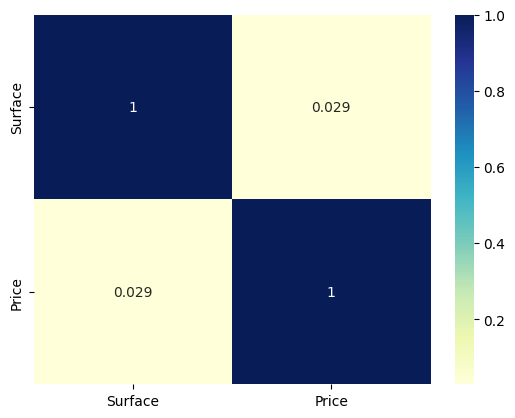

In [71]:
corr = otodf_1.corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu')
# plt.show()

**Wnioski**

Nasze założenie było jednak błędne, korelacja jest co prawda dodatnia, ale bardzo niska. To na pewno będzie więc za mało dla naszego modelu regresji, aby na podstawie samej tylko powierzchni generować predykcję ceny.

Zobaczmy jeszcze na wykres typu scatter jak to wygląda.

<Axes: >

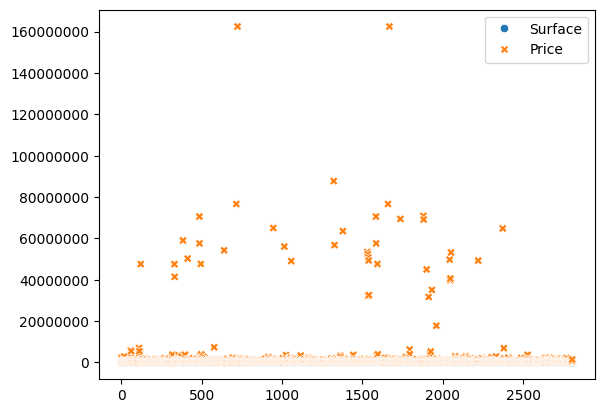

In [72]:
f, ax = plt.subplots()
ax.ticklabel_format(style='plain', axis='both')
sns.scatterplot(otodf_1, ax=ax)

Widać wyraźnie, że mamy tu do czynienia z wartościami odstającymi, które będą zaburzały model.

Widać to również bardzo wyraźnie na wykresie typu boxplot poniżej, gdzie box ze średnią, medianą oraz percentylami 25 i 75 nie jest właściwie widoczny.

<Axes: ylabel='Surface'>

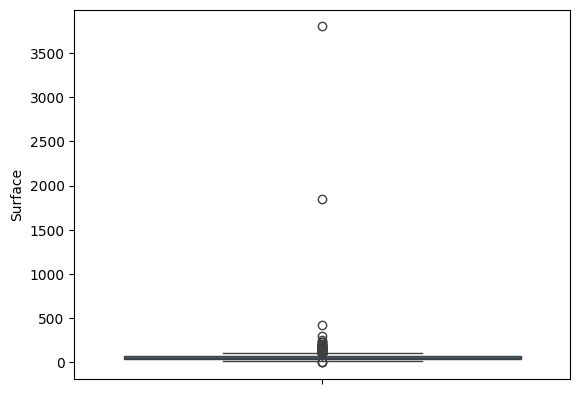

In [73]:
sns.boxplot(otodf_1['Surface'])

Wyświetlone podsumowanie głównym statystyk opisowych daje nam bardziej wymierny obraz sytuacji dla podzbioru.

In [74]:
pd.options.display.float_format = '{:.3f}'.format
otodf_1.describe()

,Surface,Price
count,2664.000,2664.000
mean,61.561,1568792.503
std,84.643,7945282.597
min,1.000,44444.000
25%,43.000,395000.000
50%,54.400,573000.000
75%,69.000,780000.000
max,3800.000,162499380.000


Jest wiele metod radzenia sobie z danymi odstającymi (ang. outliers), ale tnie jest to istotą tego labu. Dla przykładu wykorzystane zostaną tutaj przykłady z odcięciem części obserwacji odstających.

Wartości odstające wyliczamy różnymi miarami rozrzutu danych, często wykorzystując rozstęp ćwiartkowy (ang. interquantile range, w skrócie IQR).

Poniżej podstawowe informacje o tym jak jest wyliczany, a następnie policzymy go dla naszego podzbioru.

![boxplot](https://github.com/VitaMInkAaA/MAD_laboraturium_Yurii_Vrotnyy/blob/main/lab_12/boxplot.png?raw=1)

_(źródło: https://www.geeksforgeeks.org/interquartile-range-and-quartile-deviation-using-numpy-and-scipy/)_

**Rozstęp ćwiartkowy to różnica Q3 oraz Q1:**

_IQR= Q3 − Q1_

Jednym ze sposobów na wskazanie wartości odstających jest wykorzystanie wyliczonego **IQR** tak, że wszystkie wartości, które znajdują się poniżej **Q1 – 1.5*IQR** lub powyżej **Q3 + 1.5*IQR** mogą być traktowane jako wartości odstające.

Policzmy zatem te wartości dla naszego podzbioru.

In [75]:
# policzymy wartości kwantyli dla kolumny Surface
q1 = np.percentile(otodf_1['Surface'], 25)
q3 = np.percentile(otodf_1['Surface'], 75)
iqr = q3 - q1

# teraz progi dla wartości odstających
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

print(f'Q1: {q1}', f'Q3: {q3}', f'IQR: {iqr}', f'Lower outlier threshold: {lower}', f'Upper outlier threshold: {upper}', sep='\n')

Q1: 43.0
Q3: 69.0
IQR: 26.0
Lower outlier threshold: 4.0
Upper outlier threshold: 108.0


Te wartości spróbujemy wykorzystać później do porównania jakości różnych modeli regresji, które stworzymy dla tego zbioru.

### 1.2 Szacowanie parametrów regresji

Wykorzystując biblioteke `scikit-learn` stworzymy model regresji dla naszego podzbioru bez jego modyfikacji, jako model bazowy.

In [76]:
# 1. podział danych na 4 podzbiory
X = otodf_1['Surface']
y = otodf_1['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

<Axes: ylabel='Surface'>

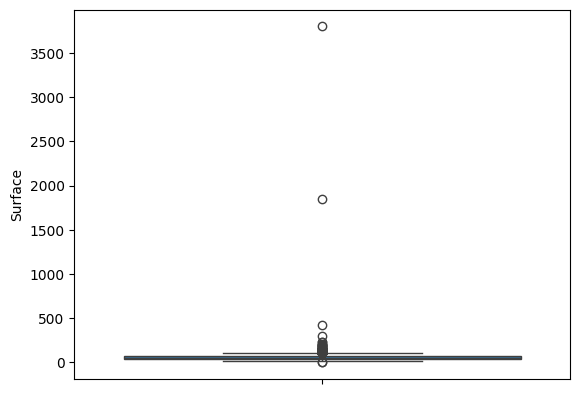

In [77]:
sns.boxplot(X_train)

In [78]:
# 2. tworzenie modelu regresji

lin_reg = LinearRegression()

# Dopasowuje model regresji liniowej
lin_reg.fit(X_train.values.reshape(-1,1), y_train)

# Przewiduje wartości na podstawie zestawu testowego
predictions = lin_reg.predict(X_test.values.reshape(-1,1))

# Wyświetla wartości punktu przecięcia z osią x i współczynników modelu
print("Punkt przecięcia:", lin_reg.intercept_)
print("Współczynniki:", lin_reg.coef_)

Punkt przecięcia: 1393959.8884245749
Współczynniki: [2375.36188693]


In [79]:
# wyliczmy również miary modelu tak jak na wykładzie
print('Średni błąd bezwzględny (MAE):', mean_absolute_error(y_test, predictions))
print("Błąd średniokwadratowy (MSE):", mean_squared_error(y_test, predictions))
print("Pierw. błędu średniokwadratowego (RMSE):", np.sqrt(mean_squared_error(y_test, predictions)))
print("Współczynnik determinacji R-kwadrat:", r2_score(y_test, predictions))

Średni błąd bezwzględny (MAE): 1875141.134351934
Błąd średniokwadratowy (MSE): 81450569367726.75
Pierw. błędu średniokwadratowego (RMSE): 9024996.917879073
Współczynnik determinacji R-kwadrat: 0.0004911898590828079


Można już na tej podstawie wywnioskować, że model jest słaby, gdyż wartość funkcji błędów jest wysoka, a miara R2 jest bardzo niska.
Ten wynik był jednak do przewidzenia biorąc pod uwagę wcześniejszą analizę danych tylko dla tej jednej cechy (`Surface`) względem ceny (`Price`).

Tutaj również widać, że model nie posiada wysokiej zależności liniowej, więc regresj aliniowa może nie być dobrym podejściem do modelowania tego zbioru.

**Uwaga!**

Pamiętajmy, że te wyniki są wynikami tylko dla jednej próby losowego wyboru zbioru treningowego i testowego. W realnych scenariuszach chcemy taki podział wykonać wiele razy (im więcej tym uzyskane wyniki będą obarczone mniejszym wpływem losowości) i wyliczyć uśrednione wyniki (accuracy, MSE, itp.).

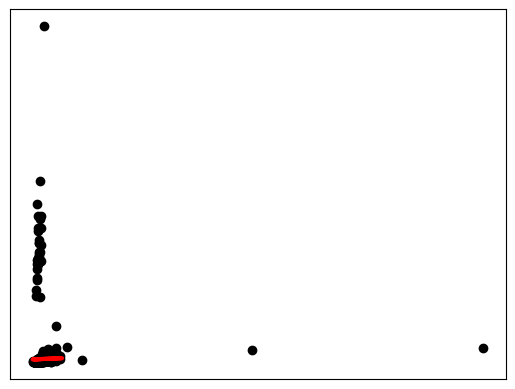

In [80]:
# wyświetlamy wyliczoną linię regresji
plt.scatter(X_train, y_train, color="black")
plt.plot(X_test, predictions, color="red", linewidth=3)
# lub tak
# lcoef_ = lin_reg.coef_ * X_test + lin_reg.intercept_
# plt.plot(X_test, lcoef_, color="red", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [81]:
# teraz sprónujemy wykorzystać wyliczone miary wartości odstających, aby zobaczyć, czy przyniesie to lepszy wynik
# podział danych pozostaje taki jak jest, zmodyfikujemy tylko dwa podzbiory X_train, y_train, gdyż z danych
# treningowych chcemy pozbyć się wartości odstających

q1 = np.percentile(X_train, 25)
q3 = np.percentile(X_train, 75)
iqr = q3 - q1

# teraz progi dla wartości odstających
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# ile jest tych wartości odstających?
sum((X_train > upper) | (X_train < lower))

105

In [82]:
(X_train > upper) | (X_train < lower)

,Surface
1893,True
1324,False
2065,False
2428,False
1593,False
...,...
1833,False
809,False
892,False
1748,False


In [83]:
outliers_map = ((X_train > upper) | (X_train < lower))
# odrzucamy pozycje gdzie wykryto wartości odstające
# znak ~ oznacza negację

outliers_map = outliers_map
X_train = X_train[~outliers_map]
y_train = y_train[~outliers_map]

<Axes: ylabel='Surface'>

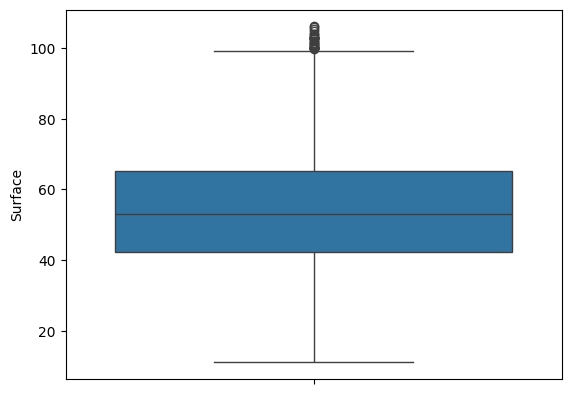

In [84]:
# po usunięciu wartości odstających
# lepiej, ale wciąż nie jest zbyt dobrze
sns.boxplot(X_train)

In [85]:
# trenujemy model raz jeszcze na danych bez wartości odstających
lin_reg = LinearRegression()

# Dopasowuje model regresji liniowej
lin_reg.fit(X_train.values.reshape(-1,1), y_train)

# Przewiduje wartości na podstawie zestawu testowego
predictions = lin_reg.predict(X_test.values.reshape(-1,1))

# Wyświetla wartości punktu przecięcia z osią x i współczynników modelu
print("Punkt przecięcia:", lin_reg.intercept_)
print("Współczynniki:", lin_reg.coef_)

Punkt przecięcia: 541985.1059085288
Współczynniki: [17715.3771551]


In [86]:
# wyliczmy również miary modelu tak jak na wykładzie
print('Średni błąd bezwzględny (MAE):', mean_absolute_error(y_test, predictions))
print("Błąd średniokwadratowy (MSE):", mean_squared_error(y_test, predictions))
print("Pierw. błędu średniokwadratowego (RMSE):", np.sqrt(mean_squared_error(y_test, predictions)))
print("Współczynnik determinacji R-kwadrat:", r2_score(y_test, predictions))

Średni błąd bezwzględny (MAE): 1909086.983911204
Błąd średniokwadratowy (MSE): 81282213913544.39
Pierw. błędu średniokwadratowego (RMSE): 9015664.917993814
Współczynnik determinacji R-kwadrat: 0.0025571393177151736


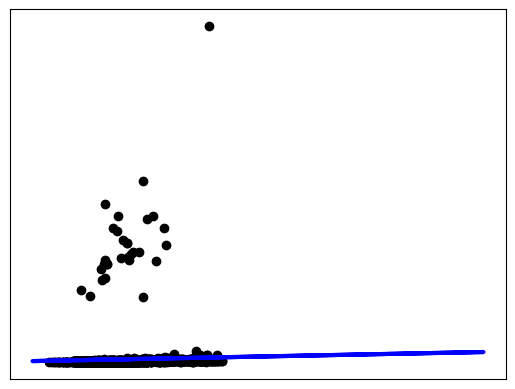

In [87]:
# wyświetlamy wyliczoną linię regresji
plt.scatter(X_train, y_train, color="black")
plt.plot(X_test, predictions, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

**Wnioski**

Model wydaje się lepiej dopasowany do danych, ale na pewno widać mniejszy wpływ danych odstających.

Daleko jendak jest jeszcze do końca naszej pracy.

## Zadania

**Zadanie 1**

Bazując na przykładzie z wykładu stwórz model regresji wielomianowej dla dwóch stworzonych tutaj modeli regresji liniowej. Porównaj wyniki.

**Zadanie 2**

Dodaj do zbioru danych cechę `Number of rooms` i sprawdź jak to wpływa na jakość modelu.

**Zadanie 3**

Zakoduj cechę `Voivoideship` (one-hot, dummy ?) i wykorzystaj w zbiorze danych i ponownie sprawdź jaki to ma wpływ na model.

**Zadanie 4** *

Dodaj kolejne cechy modelu zastanawiając się nad poprawnym ich zakodowaniem, tak aby poprawić jego jakość.

\* zadanie opcjonalne (może być brane pod uwagę w przypadku wątpliwości co do finalnej oceny).

### Przykład wielu powtórzeń tego samego eksperymentu (model regresji) i wyliczenie średnich wyników

In [56]:
from tqdm import tqdm

X = otodf_1['Surface'].values.reshape(-1, 1)
y = otodf_1['Price']

iters = 1000
lin_reg = LinearRegression()
results = {'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

for i in tqdm(range(1, iters + 1)):
    # data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    # fit the model
    lin_reg.fit(X_train, y_train)
    predictions = lin_reg.predict(X_test)
    results['MAE'].append(mean_absolute_error(y_test, predictions))
    results['MSE'].append(mean_squared_error(y_test, predictions))
    results['RMSE'].append(np.sqrt(mean_squared_error(y_test, predictions)))
    results['R2'].append(r2_score(y_test, predictions))

# average of the results
for key, value in results.items():
    print(f'Average {key}: {np.mean(value)}')

100%|██████████| 1000/1000 [00:10<00:00, 96.03it/s]

Average MAE: 1831770.165913878
Average MSE: 62317819119043.33
Average RMSE: 7710697.133811029
Average R2: -0.008816867926145017


In [57]:
# usunięcie wartości odstających w kolumnie Surface

iters = 1000
lin_reg = LinearRegression()
results = {'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

for i in tqdm(range(1, iters + 1)):
    # data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # remove outliers
    q1 = np.percentile(X_train, 25)
    q3 = np.percentile(X_train, 75)
    iqr = q3 - q1
    # teraz progi dla wartości odstających
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    # ocinamy wartości odstające
    outliers_map = (X_train > upper) | (X_train < lower)
    outliers_map = outliers_map.flatten()
    # znak ~ oznacza negację
    X_train = X_train[~outliers_map]
    y_train = y_train[~outliers_map]


    # fit the model
    lin_reg.fit(X_train, y_train)
    predictions = lin_reg.predict(X_test)
    results['MAE'].append(mean_absolute_error(y_test, predictions))
    results['MSE'].append(mean_squared_error(y_test, predictions))
    results['RMSE'].append(np.sqrt(mean_squared_error(y_test, predictions)))
    results['R2'].append(r2_score(y_test, predictions))

# average of the results
for key, value in results.items():
    print(f'Average {key}: {np.mean(value)}')

100%|██████████| 1000/1000 [00:04<00:00, 208.74it/s]

Average MAE: 1900449.3660014637
Average MSE: 64381080961050.72
Average RMSE: 7858214.610388136
Average R2: -0.08566631056993199


<Axes: ylabel='Count'>

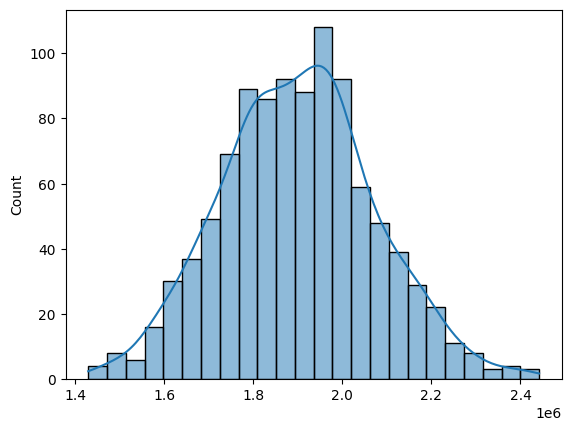

In [58]:
sns.histplot(results['MAE'], kde=True)

In [59]:
# dodanie standaryzacji danych w kolumnie surface
from sklearn.preprocessing import StandardScaler, Normalizer

iters = 1000
lin_reg = LinearRegression()
results = {'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

for i in tqdm(range(1, iters + 1)):
    # data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    # data scaling or normalizing - choose only one at a time!
    # scaler = StandardScaler()
    normalizer = Normalizer()
    # scaler.fit(X_train)
    normalizer.fit(X_train)


    # fit the model
    lin_reg.fit(X_train, y_train)

    # scale test data
    # X_test = scaler.transform(X_test)
    X_test = normalizer.transform(X_test)

    predictions = lin_reg.predict(X_test)
    results['MAE'].append(mean_absolute_error(y_test, predictions))
    results['MSE'].append(mean_squared_error(y_test, predictions))
    results['RMSE'].append(np.sqrt(mean_squared_error(y_test, predictions)))
    results['R2'].append(r2_score(y_test, predictions))

# average of the results
for key, value in results.items():
    print(f'Average {key}: {np.mean(value)}')

100%|██████████| 1000/1000 [00:05<00:00, 197.88it/s]

Average MAE: 1667053.3658926988
Average MSE: 63703641412129.234
Average RMSE: 7795248.842920299
Average R2: -0.0027751331409468305


Text(0, 0.5, 'Oś y')

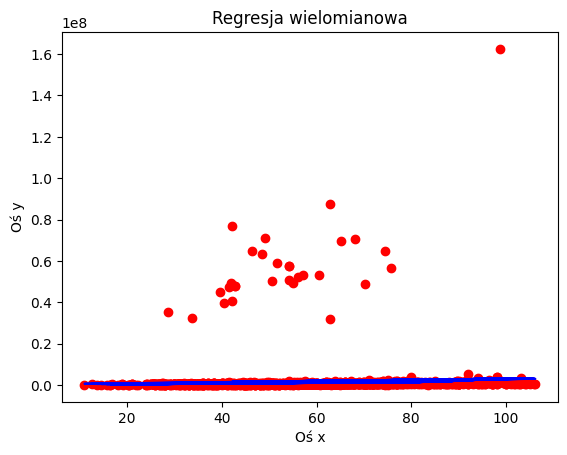

In [90]:
#zad 1
data = pd.DataFrame({"X":X_train,
                     "y":y_train})
sns.scatterplot(data=data, x="X", y="y")
X = data[['X']]
y = data[['y']]

polynomial_reg = PolynomialFeatures(degree = 6)
X_polynomial = polynomial_reg.fit_transform(X)

linear_reg = LinearRegression()
linear_reg.fit(X_polynomial, y)
predictions=linear_reg.predict(X_polynomial)

plt.scatter(X,y, color = 'red')
plt.plot(X, predictions, color = 'blue')
plt.title('Regresja wielomianowa')
plt.xlabel('Oś x')
plt.ylabel('Oś y')

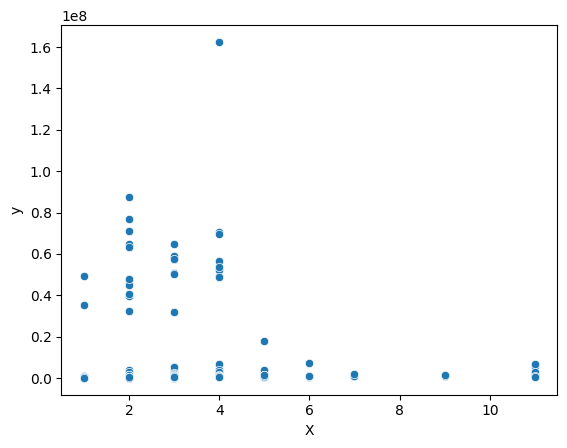

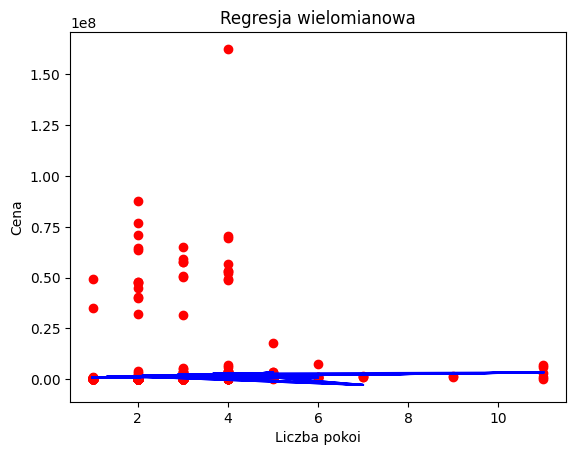

In [93]:
#zad 2
otodf_2 = otodf[['Surface', 'Price', 'Number_of_Rooms']].dropna()
otodf_2['Number_of_Rooms'] = otodf_2['Number_of_Rooms'].replace("więcej niż 10", '11')
otodf_2['Number_of_Rooms'] = pd.to_numeric(otodf_2['Number_of_Rooms'])
X = otodf_2['Number_of_Rooms']
y = otodf_2['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
sns.scatterplot(data=data, x="X", y="y")
X = data[['X']]
y = data[['y']]
polynomial_reg = PolynomialFeatures(degree=6)
X_polynomial = polynomial_reg.fit_transform(X)
linear_reg = LinearRegression()
linear_reg.fit(X_polynomial, y)
predictions = linear_reg.predict(X_polynomial)
plt.figure()
plt.scatter(X['X'], y['y'], color='red')
plt.plot(X['X'], predictions, color='blue')
plt.title('Regresja wielomianowa')
plt.xlabel('Liczba pokoi')
plt.ylabel('Cena')
plt.show()

Text(0, 0.5, 'Oś y')

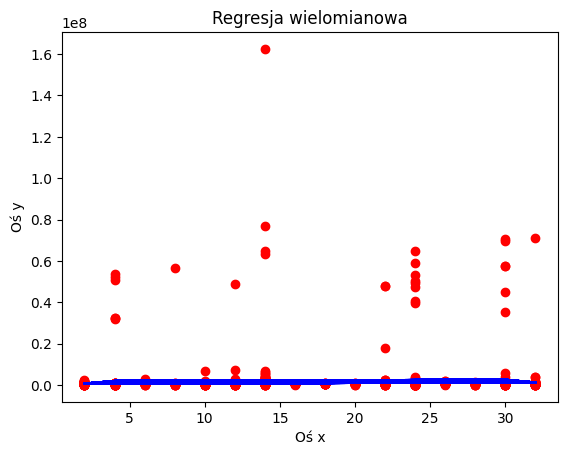

In [96]:
#zad 3

Voivodeship_map = {"Dolnośląskie": 2, "Kujawsko-pomorskie": 4, "Lubelskie": 6,
                    "Lubuskie": 8, "Łódzkie":10,"Małopolskie":12,"Mazowieckie":14,
                    "Opolskie":16, "Podkarpackie":18,"Podlaskie":20,"Pomorskie":22,
                    "Śląskie":24,"Świętokrzyskie":26,"Warmińsko-mazurskie":28,
                    "Wielkopolskie":30,"Zachodniopomorskie":32}

otodf_3 = otodf[['Surface', 'Price','Voivodeship']]
otodf_3 = otodf_3.dropna()
otodf_3['Voivodeship'] = otodf_3['Voivodeship'].map(Voivodeship_map)
otodf_3
X = otodf_3['Voivodeship']
y = otodf_3['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
data = pd.DataFrame({"X":X_train,
                     "y":y_train})
sns.scatterplot(data=data, x="X", y="y")
X = data[['X']]
y = data[['y']]

polynomial_reg = PolynomialFeatures(degree = 6)
X_polynomial = polynomial_reg.fit_transform(X)

linear_reg = LinearRegression()
linear_reg.fit(X_polynomial, y)
predictions=linear_reg.predict(X_polynomial)

plt.scatter(X,y, color = 'red')
plt.plot(X, predictions, color = 'blue')
plt.title('Regresja wielomianowa')
plt.xlabel('Oś x')
plt.ylabel('Oś y')